In this notebook we want to predict Bitcoin price using python and machin learning (LSTM network).

So first of all we will import the libraries that we want to use in this notebook

In [3]:
import math
import pandas_datareader as dr
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [6]:
# Data Frame did import from google colab.
# You can upload the data frame on your google drive and mounting the drive with the google clab
btc = yf.download('BTC-USD', start='2017-09-11', end='2023-11-20')

[*********************100%%**********************]  1 of 1 completed


In [5]:
btc.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-15,35548.113281,37964.894531,35383.781250,37880.582031,37880.582031,27365821679
2023-11-16,37879.980469,37934.625000,35545.472656,36154.769531,36154.769531,26007385366
2023-11-17,36164.824219,36704.484375,35901.234375,36596.683594,36596.683594,22445028430
2023-11-18,36625.371094,36839.281250,36233.312500,36585.703125,36585.703125,11886022717
2023-11-19,36585.765625,37509.355469,36414.597656,37386.546875,37386.546875,12915986553


In [61]:
# Checking the shape of our original data frame
btc.shape

(2261, 6)

Now let's plot our close price only. We wanna use the **dailty close price** of Bitcoin for our model in this notebook so we only plot **close price**

In [1]:
#show BTC close price
plt.figure(figsize=(16,8))
plt.title('BTC Close Price', fontsize=24)
plt.plot(btc['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

NameError: name 'plt' is not defined

So as we want to work only with Close Price, let's use `.filter` methode.
then we will import the values of the close price column in `data` variable to `dataset` variable.

In [63]:
#Creat a new dataframe with only Close Price
data = btc.filter(['Close'])
#Convert the dataframe to numpy array
dataset = data.values
# Get the number of rows to train the model on. we need this number to create our train and test sets
# math.ceil will round up the number
training_data_len = math.ceil(len(dataset) * .8) # We are using %80 of the data for training
training_data_len

1809

Now that we have our close price values in a seprated dataframe we can start normalization our data.

In [64]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01562321],
       [0.01515031],
       [0.01129668],
       ...,
       [0.51918582],
       [0.51901535],
       [0.53144851]])

In this case, we can't use `train_test_split` function, because we need our train and test sets to be **Sequential Data**. LSTM network needs to have the *last output values* of network layer for the *input of the next layer* of network. So we can't use `train_test_split` and randomize our train/test data.

Our model will predict the price by looking the last 60 days of price. this will help our model to predict a better price and not just a random number that would have less than %50 accuracy.

In [65]:
# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]
# Split the data into X_train and y_train data sets
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])


  if i <= 60:
    print(X_train)
    print(y_train)
    print()

[array([0.01562321, 0.01515031, 0.01129668, 0.        , 0.00749194,
       0.00729819, 0.00664365, 0.01413171, 0.01195463, 0.01165934,
       0.00739134, 0.00738606, 0.00989647, 0.00819554, 0.01197171,
       0.0114482 , 0.01623489, 0.01583217, 0.01565115, 0.01837798,
       0.01938758, 0.0194742 , 0.01804838, 0.01668031, 0.01821807,
       0.01887633, 0.01974698, 0.02259723, 0.02510515, 0.02525994,
       0.02595065, 0.03558288, 0.03869255, 0.04155817, 0.03917352,
       0.03990941, 0.03804515, 0.03781507, 0.0396444 , 0.04434741,
       0.04466024, 0.04430037, 0.04308786, 0.0368207 , 0.04030079,
       0.04269213, 0.0407681 , 0.04033635, 0.04655819, 0.04619614,
       0.0514416 , 0.0560822 , 0.06091346, 0.06292022, 0.0655935 ,
       0.06601981, 0.06004808, 0.06193625, 0.06683146, 0.06192383])]
[0.053766328257045616]



In [66]:
len(X_train)

1749

So now X_train has 2083 array which any of them contains 60 days of price in them and y_train contains 2083 days of price which is the price of the last 60 days.

LSTM model needs the data to be an *array*. So here we will convert X_train and y_train to an array list.

In [67]:
# Convert the X_train and y_train to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [68]:
X_train.shape

(1749, 60)

By the way, LSTM needs the data to be inputet by 3 dimension. So we will reshape X_train to a 3-dim array

In [69]:
# Reshape the data because LSTM needs 3 dim
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # we make it like pros. it wanna say "np.reshape(X_train, (2083, 60, 1))"
X_train.shape

(1749, 60, 1)

Now that we finish creating our train data, we can create our *test data* (Just like how we did with train data).

In [70]:
# Create the testing dataset
# Create a new array containing scaled values from index 2083
test_data = scaled_data[training_data_len - 60 : , :]

#Create the data sets X_test and y_test
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60 : i, 0])


In [71]:
# Convert the data to a numpy array
X_test = np.array(X_test)

In [72]:
# Reshape the test data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Here we getting to the fun part, **Creating the model**

We are using 2 layers of LSTM and 2 layers of Dense. Our first LSTM layer has `return_sequence=True` because our first and second layers are LSTM and we have to pass the output of the first layer to the second layer. (Again: **LSTM is a Network for Sequential Data**)

Our last layer only has one unit in it while we need only one number (one price) to predict.

In [73]:
# Build LSTM model
tf.random.set_seed(42)

model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) , the simple form is "input_shape(60, 1)""
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(25))
model_1.add(Dense(1))

In [74]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')

We will store the steps of each epochs in `history` variable. We are doing this to ploting the loss and finding the best number of epochs to avoid overfiting training.

Here we make a variable call `callback` which has the job to stop training the model whenever the *loss* is no longer decreasing.

(for more detail check the [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) library)

In [76]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1749/1749 [==============================] - 20s 11ms/step - loss: 8.7900e-04
Epoch 2/10
1749/1749 [==============================] - 21s 12ms/step - loss: 6.2945e-04
Epoch 3/10
1749/1749 [==============================] - 20s 12ms/step - loss: 6.0720e-04
Epoch 4/10
1749/1749 [==============================] - 20s 12ms/step - loss: 5.6990e-04
Epoch 5/10
1749/1749 [==============================] - 20s 12ms/step - loss: 4.9335e-04
Epoch 6/10
1749/1749 [==============================] - 20s 12ms/step - loss: 5.4137e-04
Epoch 7/10
1749/1749 [==============================] - 20s 12ms/step - loss: 4.4351e-04
Epoch 8/10
1749/1749 [==============================] - 21s 12ms/step - loss: 4.9714e-04
Epoch 9/10
1749/1749 [==============================] - 22s 13ms/step - loss: 4.6964e-04
Epoch 10/10
1749/1749 [==============================] - 20s 12ms/step - loss: 4.4611e-04


In [77]:
# Get the model_1 predicted price values
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
len(predictions_1)

15/15 [==============================] - 1s 8ms/step


452

In [78]:
# Get the root mean squared error (RMSE) for model_1
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse

989.125483960177

Text(0.5, 0, 'epochs')

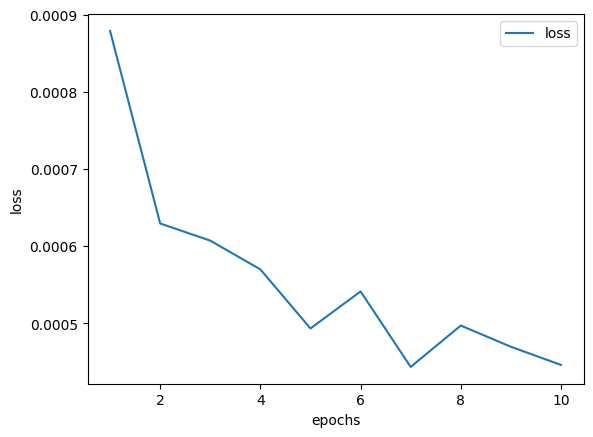

In [79]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

C:\Users\Dan\AppData\Local\Temp\ipykernel_23912\1769193438.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_1['Predictions'] = predictions_1


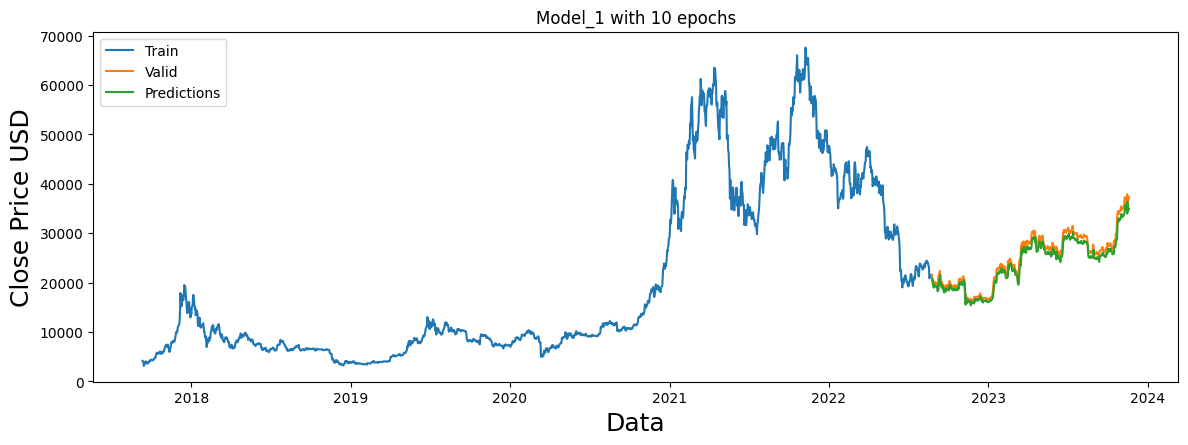

In [81]:
# Plot the data
train = data[:training_data_len]

#data for model_1
valid_1 = data[training_data_len:]
valid_1['Predictions'] = predictions_1

# Visualized the data
#model_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_1[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

Now it's time to predict a future day price which is not in train or test set. In other words we want to predict a price out of the dataframe which is the price of today.

So first we need to create a new variable `last_60_days` and use it to predict the today price of Bitcoin. This way we can create a new test set to creating the price of last 60 days from today (today is 1/15/2022).

In [85]:
#Get the last 60 day closing price values and convert the datadrame to an array
last_60_days = data[-30:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)
# create an empty list
new_X_test = []
# Append the past 60 days
new_X_test.append(last_60_days_scaled)
# Convert the X_test data set to a numpy array
new_X_test = np.array(new_X_test)
# Reshape the data
new_X_test = np.reshape(new_X_test, (new_X_test.shape[0], new_X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model_1.predict(new_X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 16ms/step
[[37355.37]]


In [86]:
model_1.save("model_bitcoin.h5")

c:\Users\Dan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
